## Install surprise (A python scikit for recommender systems)

In [1]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

from IPython.display import display
from tqdm import tqdm
from collections import defaultdict

seed = 0
np.random.seed(seed)
random.seed(seed)
warnings.filterwarnings(action='ignore')

## Load dataset

#### Netflix held the Netflix Prize open competition for the best algorithm to predict user ratings for films.   
#### This is the dataset that was used in that competition. It consists of user id and ratings (1~5) that a user rated to a movie.

In [3]:
# Skip date
df = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])
df['Rating'] = df['Rating'].astype(float)

print('shape: {}\n'.format(df.shape))
print('-Dataset examples-')
df.iloc[::5000000, :]

shape: (13096730, 2)

-Dataset examples-


,Cust_Id,Rating
0,1:,NaN
5000000,2560324,4.0
10000000,2271935,2.0


## The shape of the dataset

#### - The dataset has two columns, Cust_Id and Rating. 
#### - Each row indicates the rating that a user (Cust_Id) gave to a movie.  
#### - The row with the rating 'NaN' indicates the Movie_Id (Item_Id). 


In [4]:
display(df.loc[0:2, :])
display(df.loc[548:551, :])
display(df.loc[694:696, :])

,Cust_Id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0


,Cust_Id,Rating
548,2:,NaN
549,2059652,4.0
550,1666394,3.0
551,1759415,4.0


,Cust_Id,Rating
694,3:,NaN
695,1025579,4.0
696,712664,5.0


## Add movie ID column

In [5]:
ratings = df.Rating.values
movie_id_arr = np.cumsum(np.isnan(ratings))
df['Movie_Id'] = movie_id_arr
df = df.dropna(axis=0)
df.Cust_Id = df.Cust_Id.astype(int)

print(f'총 rating 수 : {len(df)}')
display(df.loc[::5000,:])

총 rating 수 : 13094259


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
5006,1189445,1.0,6
10008,2421394,3.0,8
15008,2342811,3.0,8
20008,1834737,3.0,8
...,...,...,...
13072465,131766,2.0,2465
13077467,176377,2.0,2467
13082470,2374247,3.0,2470
13087470,1303158,5.0,2470


In [6]:
df['Cust_Id']

1           1488844
2            822109
3            885013
4             30878
5            823519
             ...   
13096724    2336079
13096725     567522
13096726     398488
13096727     219832
13096728    2499918
Name: Cust_Id, Length: 13094259, dtype: int64

In [7]:
p = df.groupby('Rating')['Rating'].agg(['count'])

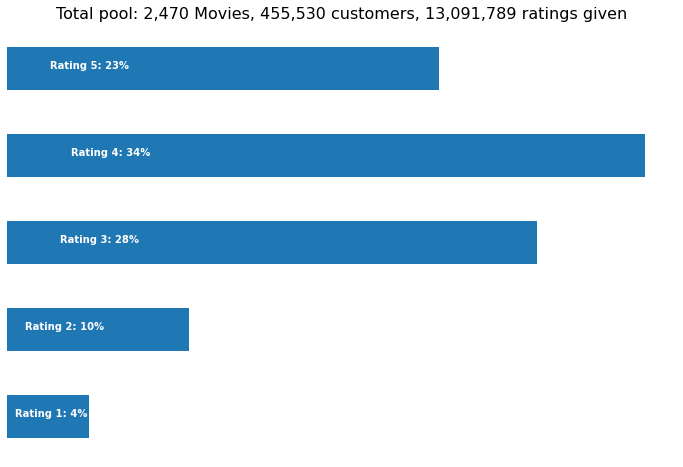

In [8]:
# get movie count
movie_count = df.Movie_Id.nunique()

# get customer count
cust_count = df['Cust_Id'].nunique() - movie_count

# get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (12,8))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=16)
plt.axis('off')

for i in range(1, 6):
    ax.text(p.iloc[i-1][0]/10, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

## Movie ID-Title dataset

In [9]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print(df_title.shape)
df_title.head(10)

(17770, 2)


,Year,Name
Movie_Id,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW
6,1997.0,Sick
7,1992.0,8 Man
8,2004.0,What the #$*! Do We Know!?
9,1991.0,Class of Nuke 'Em High 2


## Build the dataset (user-item matrix)

#### For the fast implementation, I randomly select 500 users and their all interactions.

In [10]:
from surprise import Reader, Dataset

In [11]:
reader = Reader()

# just get interactions of 500 users randomly
n_users = 500
all_users = df.Cust_Id.unique()
sampled_users = np.random.choice(all_users, n_users, replace=False)
df_sample = df.loc[df['Cust_Id'].isin(sampled_users)]
df_sample

,Cust_Id,Rating,Movie_Id
640,1783594,5.0,2
3831,691460,3.0,5
4162,556633,3.0,6
4631,1291710,4.0,6
5528,1644477,1.0,8
...,...,...,...
13092008,2128893,2.0,2470
13092147,2630962,1.0,2470
13092900,2393834,4.0,2470
13092976,1549096,3.0,2470


In [12]:
print('{} interactions, {} users, {} movies are selected.'.format(len(df_sample), df_sample.Cust_Id.nunique(), df_sample.Movie_Id.nunique()))
print('only {:.2f}% of possible interactions are observed'.format(len(df_sample) / (df_sample.Cust_Id.nunique()*df_sample.Movie_Id.nunique()) *100))

data = Dataset.load_from_df(df_sample[['Cust_Id', 'Movie_Id', 'Rating']], reader)
unobserved_data = data.build_full_trainset().build_anti_testset()


14216 interactions, 500 users, 1370 movies are selected.
only 2.08% of possible interactions are observed


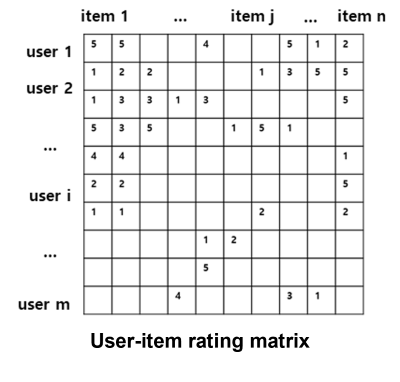

In [13]:
unobserved_data[:10]

[(1783594, 5, 3.61648846370287),
 (1783594, 6, 3.61648846370287),
 (1783594, 8, 3.61648846370287),
 (1783594, 10, 3.61648846370287),
 (1783594, 15, 3.61648846370287),
 (1783594, 16, 3.61648846370287),
 (1783594, 17, 3.61648846370287),
 (1783594, 18, 3.61648846370287),
 (1783594, 19, 3.61648846370287),
 (1783594, 23, 3.61648846370287)]

In [14]:
# 리뷰어 ID, 영화 ID, 평점, 시간
data.raw_ratings[:10]

[(1783594, 2, 5.0, None),
 (691460, 5, 3.0, None),
 (556633, 6, 3.0, None),
 (1291710, 6, 4.0, None),
 (1644477, 8, 1.0, None),
 (847545, 8, 3.0, None),
 (107840, 8, 2.0, None),
 (153531, 8, 5.0, None),
 (2003927, 8, 3.0, None),
 (1121033, 8, 3.0, None)]

### Train the model

* In this part, we train two matrix factorization models for recommendation, **SVD**(Singular Value Decomposition) and **NMF**(Nonnegative Matrix Factorization)

In [15]:
from surprise import SVD, NMF, accuracy
from surprise.model_selection import cross_validate

# hyperparameters for training the model
n_factors = 30
n_epochs = 100
biased = True
# lr_all = 0.005
# reg_all = 0.02

In [16]:
# initialize SVD 
algo = SVD(n_factors = n_factors, n_epochs = n_epochs, biased = biased, random_state = seed )


In [17]:
# cross validation of SVD
cv_result = cross_validate(algo, data, measures = ['RMSE','MAE'], cv = 5, verbose = True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.0552  1.0346  1.0307  1.0505  1.0849  1.0512  0.0192  
MAE (testset)     0.8306  0.8148  0.8064  0.8299  0.8479  0.8259  0.0143  
Fit time          4.59    4.45    4.00    1.71    1.70    3.29    1.31    
Test time         0.03    0.04    0.10    0.02    0.02    0.04    0.03    


In [18]:
# initialize NMF
algo = NMF(n_factors = n_factors, n_epochs = n_epochs, biased = biased, random_state = seed)


In [19]:
# cross validation of NMF
cv_result = cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)


Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.9165  1.7902  1.5236  1.9013  2.0453  1.8354  0.1756  
MAE (testset)     1.5513  1.4248  1.1726  1.5298  1.6728  1.4703  0.1684  
Fit time          2.43    2.36    2.37    2.37    2.37    2.38    0.02    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


In [20]:
# find the best hyperparapmeter of your model by gridsearchCV

from surprise.model_selection import GridSearchCV

param_grid = {
    'n_factors': [30, 50, 70, 100], 
    'n_epochs': [50, 100]
    }
gs = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv = 3)
gs.fit(data)

In [21]:
print('Best RMSE: {:.5f} | params for the best RMSE: {}'.format(gs.best_score['rmse'], gs.best_params['rmse']))
print('Best MAE: {:.5f} | params for the best MAE: {}'.format(gs.best_score['mae'], gs.best_params['mae']))

Best RMSE: 0.99524 | params for the best RMSE: {'n_factors': 100, 'n_epochs': 50}
Best MAE: 0.78523 | params for the best MAE: {'n_factors': 50, 'n_epochs': 50}


### See how matrix factorization estimates unknown ratings

In [22]:
n_factors, n_epochs = gs.best_params['rmse']['n_factors'], gs.best_params['rmse']['n_epochs']

# initialize the model
algo = SVD(n_factors=n_factors, n_epochs=n_epochs, biased=biased, random_state=seed)
# trainset is the total observed ratings
trainset = data.build_full_trainset()
# train the model with the trainset
algo.fit(trainset)
# predict the values of unobserved ratings
unobserved_pred = algo.test(unobserved_data)

In [23]:
unobserved_pred[:10]

[Prediction(uid=1783594, iid=5, r_ui=3.61648846370287, est=3.658201585169086, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=6, r_ui=3.61648846370287, est=3.6698253679022366, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=8, r_ui=3.61648846370287, est=3.448362821394407, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=10, r_ui=3.61648846370287, est=3.6203879833744375, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=15, r_ui=3.61648846370287, est=3.7409416634199966, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=16, r_ui=3.61648846370287, est=3.646538902077693, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=17, r_ui=3.61648846370287, est=3.3988238695417325, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=18, r_ui=3.61648846370287, est=3.5667880149332567, details={'was_impossible': False}),
 Prediction(uid=1783594, iid=19, r_ui=3.61648846370287, est=3.8942557998895944

In [24]:
# caclulate RMSE and MAE for the test set
from sklearn import metrics

y_pred = []
y_true = []
for _, _, true, pred, _ in unobserved_pred:
  y_pred.append(pred)
  y_true.append(true)

RMSE = metrics.mean_squared_error(y_true, y_pred)
MAE = metrics.mean_absolute_error(y_true, y_pred)
print(f'RMSE: {RMSE}')
print(f'MAE: {MAE}')

RMSE: 0.22281758713161037
MAE: 0.37114730510623184


In [25]:
user_dict = {i:trainset.to_raw_uid(i) for i in trainset.all_users()} # raw user id: encoded user id
item_dict = {i:trainset.to_raw_iid(i) for i in trainset.all_items()} # raw item id: encoded item id

In [26]:
print('(encoded id, raw id):', list(user_dict.items())[:5])
print('(encoded id, raw id)    :', list(item_dict.items())[:5])

(encoded id, raw id): [(0, 1783594), (1, 691460), (2, 556633), (3, 1291710), (4, 1644477)]
(encoded id, raw id)    : [(0, 2), (1, 5), (2, 6), (3, 8), (4, 10)]


In [27]:
# select a user and an item as a sample
uid = 0
iid = 0

pu = algo.pu[uid]
qi = algo.qi[iid]
bu = algo.bu[uid]
bi = algo.bi[iid]

print('Shape of user latent vector (p_u) = (n_user, n_latent)={}: \nEx) User factor of user {} (raw id: {})\n{}\n'.format(algo.pu.shape, uid, user_dict[uid], pu))
print('Shape of item latent vector (q_i) = (n_item, n_latent)={}: \nEx) Item factor of movie {} (raw id: {})\n{}\n'.format(algo.qi.shape, iid, item_dict[iid], qi))
print('Shape of user bias (b_u) = (n_user, )={}: \nEx) User bias of user {} (실제 id: {}): {}\n'.format(algo.bu.shape, uid, user_dict[uid], bu))
print('Shape of item bias (b_i) = (n_item, )={}: \nEx) Item bias of movie {} (실제 id: {}): {}'.format(algo.bi.shape, iid, item_dict[iid], bi))

Shape of user latent vector (p_u) = (n_user, n_latent)=(500, 100): 
Ex) User factor of user 0 (raw id: 1783594)
[ 1.75687677e-01  8.09246796e-02  5.98751375e-02  2.07310239e-01
  1.40170902e-01 -1.23964347e-01  9.80947418e-02 -3.42671790e-02
 -4.96894963e-02 -1.19707389e-02  2.53374844e-02  1.19660790e-01
  1.37152140e-01  6.31893756e-02  4.64015840e-02 -1.08030514e-02
  1.68703818e-01 -3.69642566e-02  2.51945406e-02 -3.05222413e-02
 -2.57184620e-01  5.35506913e-02  8.43962730e-02 -4.81014996e-02
  2.29514706e-01 -1.34423767e-01 -1.91425475e-02 -5.54678365e-02
  1.47024001e-01  1.72484691e-01 -2.15073538e-02  1.39217478e-02
 -9.01174247e-02 -2.01669510e-01 -5.97348770e-02 -2.23070787e-02
  1.41971887e-01  9.70891075e-02 -2.21151213e-02 -7.18928274e-03
 -8.90165082e-02 -1.35060859e-01 -1.87892709e-01  2.33722992e-01
 -4.31371219e-02 -4.37240286e-02 -9.42139332e-02  7.55984270e-02
 -1.39148269e-01 -2.68018422e-02 -9.08525606e-02  2.68461715e-02
 -6.91008089e-02 -9.89438861e-02 -5.4400836

In [28]:
# prediction by SVD.predict method
algo.predict(user_dict[uid], item_dict[iid])

Prediction(uid=1783594, iid=2, r_ui=None, est=4.443338118718734, details={'was_impossible': False})

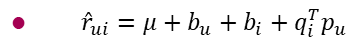

In [29]:
# manual calculation
trainset.global_mean + bu + bi + np.dot(pu, qi)

4.443338118718734

## Top-N recommendation

#### Recommend N items that a user is expected to like (items with N highest predicted ratings) to the user who has ever rated.

In [30]:
def get_top_n(predictions, user_dict, user, n=10):
    """
    Return the top-N recommendation for each user from a set of predictions.
    [(raw item id, rating estimation), ...] of size n.
    """
    top_n = []
    for uid, iid, true_r, est, _ in predictions:
        if user_dict[user] == uid:
            top_n.append((iid, est))
    top_n.sort(key = lambda x: x[1], reverse = True)
    top_n = top_n[:n]

    print('Top-{} recommendations for user {} with id: {}'.format(n, user, user_dict[user]))
    for iid, est in top_n:
      print('r_est: {:5f} | movie ID: {:>5} | name: {}'.format(est, iid, df_title.loc[iid].Name))
    
    return top_n

In [31]:
top_n = get_top_n(unobserved_pred, user_dict, user=0, n=10)

Top-10 recommendations for user 0 with id: 1783594
r_est: 4.721891 | movie ID:  2162 | name: CSI: Season 1
r_est: 4.616528 | movie ID:  2448 | name: Prime Suspect 1
r_est: 4.599329 | movie ID:   270 | name: Sex and the City: Season 4
r_est: 4.586311 | movie ID:   825 | name: Bill Cosby: Himself
r_est: 4.580064 | movie ID:   872 | name: Seven Samurai
r_est: 4.573524 | movie ID:  1174 | name: The Sandlot
r_est: 4.568722 | movie ID:  1110 | name: Secondhand Lions
r_est: 4.558172 | movie ID:   443 | name: Rabbit-Proof Fence
r_est: 4.529581 | movie ID:  1604 | name: Tae Guk Gi: The Brotherhood of War
r_est: 4.525433 | movie ID:  2102 | name: The Simpsons: Season 6


In [32]:
# we will calculate similarity betweeen suggested movies for user 0
from sklearn import metrics

latent_factors = pd.DataFrame(index = [i for i in range(0,100)])
for movie_index, est in top_n:
    movie_key = None
    for key, value in item_dict.items():
        if value == movie_index:
            movie_key = key
            break
    latent_factors[df_title.loc[movie_index].Name] = pd.Series(algo.qi[movie_key].reshape(-1))

similarity = pd.DataFrame(metrics.pairwise.cosine_similarity(latent_factors.T), index = latent_factors.columns, columns = latent_factors.columns)
display(latent_factors)
display(similarity)

,CSI: Season 1,Prime Suspect 1,Sex and the City: Season 4,Bill Cosby: Himself,Seven Samurai,The Sandlot,Secondhand Lions,Rabbit-Proof Fence,Tae Guk Gi: The Brotherhood of War,The Simpsons: Season 6
0,-0.289818,-0.098992,0.085430,-0.111271,-0.254654,-0.116234,0.116552,0.082563,0.069642,0.093577
1,-0.157341,-0.018905,-0.023448,-0.166460,0.158476,0.100093,0.139616,-0.015903,0.072107,-0.084069
2,-0.081193,-0.089654,0.106805,-0.234841,0.165039,-0.330764,0.078691,0.303736,0.132628,-0.272466
3,-0.099200,0.292632,0.209028,0.014900,-0.078800,0.102022,-0.050422,0.173572,0.013059,0.167161
4,0.059373,0.174513,0.098073,0.203656,-0.111522,0.023009,0.034716,0.042372,0.027070,-0.149679
...,...,...,...,...,...,...,...,...,...,...
95,0.088469,-0.039310,-0.150253,-0.056868,-0.059167,0.102316,0.077689,0.036702,-0.094692,-0.011265
96,-0.059385,0.068446,-0.156990,0.027379,-0.105386,-0.149425,0.232068,-0.060593,0.055159,-0.001761
97,0.326705,0.162734,-0.135373,0.170064,-0.003158,0.013059,0.156017,-0.031111,-0.021476,0.090829
98,0.044681,-0.043444,0.119273,0.008050,-0.056858,-0.014050,0.176237,-0.053851,-0.056268,-0.094911


,CSI: Season 1,Prime Suspect 1,Sex and the City: Season 4,Bill Cosby: Himself,Seven Samurai,The Sandlot,Secondhand Lions,Rabbit-Proof Fence,Tae Guk Gi: The Brotherhood of War,The Simpsons: Season 6
CSI: Season 1,1.000000,0.070654,-0.099901,0.354878,-0.039685,0.176905,0.258797,0.047933,0.070686,0.154993
Prime Suspect 1,0.070654,1.000000,0.008669,0.146703,-0.010751,0.140101,-0.042121,0.077491,0.136608,0.166806
Sex and the City: Season 4,-0.099901,0.008669,1.000000,-0.007275,-0.011722,-0.132575,0.063212,0.085498,0.062495,-0.017724
Bill Cosby: Himself,0.354878,0.146703,-0.007275,1.000000,-0.224773,0.261161,0.062359,-0.075078,0.086753,0.238055
Seven Samurai,-0.039685,-0.010751,-0.011722,-0.224773,1.000000,-0.089332,-0.106744,-0.087530,0.015573,-0.133389
The Sandlot,0.176905,0.140101,-0.132575,0.261161,-0.089332,1.000000,0.164181,-0.125571,-0.050928,0.151311
Secondhand Lions,0.258797,-0.042121,0.063212,0.062359,-0.106744,0.164181,1.000000,0.033626,0.122117,-0.110442
Rabbit-Proof Fence,0.047933,0.077491,0.085498,-0.075078,-0.087530,-0.125571,0.033626,1.000000,0.103875,-0.114820
Tae Guk Gi: The Brotherhood of War,0.070686,0.136608,0.062495,0.086753,0.015573,-0.050928,0.122117,0.103875,1.000000,-0.082748
The Simpsons: Season 6,0.154993,0.166806,-0.017724,0.238055,-0.133389,0.151311,-0.110442,-0.114820,-0.082748,1.000000


## List of movies with similar preference

#### Gives a list of N movies of similar preference of users given a query movie.

In [33]:
def similar_movies(algo, item_dict, item, n):
    
    
    query_repr = algo.qi[item] # latent vector of the item 
    key_repr = algo.qi  # latent vector of all items

    # cosine similarities b/w the query item and all items
    sim = np.dot(query_repr, key_repr.T) / (np.sqrt(sum(query_repr**2)))

    # the n most similar movies by cosine similarities of latent vectors
    # 입력한 영화와 사용자 선호에 대한 유사도가 가장 높은 n개 영화 id 
    most_similar_movies = np.argsort(sim)[::-1][:n+1]
    query_idx = np.argwhere(most_similar_movies == item)
    most_similar_movies = np.delete(most_similar_movies, query_idx)
    most_similar_movies = [item_dict[i] for i in most_similar_movies]

    print(f'Query movie : {df_title.loc[item_dict[item]].Name}\n')


    return df_title.loc[most_similar_movies]

In [34]:
similar_movies(algo, item_dict, item=10, n=10)

Query movie : Clifford: Clifford Saves the Day! / Clifford's Fluffiest Friend Cleo



,Year,Name
Movie_Id,,
1542,1993.0,Sleepless in Seattle
2200,2002.0,Collateral Damage
1289,1990.0,Look Who's Talking Too
1521,1955.0,The Trouble With Harry
175,1992.0,Reservoir Dogs
378,2003.0,Party Monster
1855,1992.0,Plymptoons
708,2000.0,The Perfect Storm
2008,2005.0,Hercules


### Visualizing the movie Factors Using t-SNE


In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, n_iter=1000, verbose=3, random_state=seed)
movie_embedding = tsne.fit_transform(algo.qi)

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 1370 samples in 0.000s...
[t-SNE] Computed neighbors for 1370 samples in 0.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1370
[t-SNE] Computed conditional probabilities for sample 1370 / 1370
[t-SNE] Mean sigma: 0.244867
[t-SNE] Computed conditional probabilities in 0.028s
[t-SNE] Iteration 50: error = 108.2220612, gradient norm = 0.3066992 (50 iterations in 0.812s)
[t-SNE] Iteration 100: error = 112.7505188, gradient norm = 0.2592441 (50 iterations in 0.754s)
[t-SNE] Iteration 150: error = 113.6864624, gradient norm = 0.2695858 (50 iterations in 0.775s)
[t-SNE] Iteration 200: error = 112.9088287, gradient norm = 0.2544375 (50 iterations in 0.676s)
[t-SNE] Iteration 250: error = 112.4141693, gradient norm = 0.2527940 (50 iterations in 0.660s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 112.414169
[t-SNE] Iteration 300: error = 4.0902271, gradient norm = 0.0034884 (50 iterations in 0

In [36]:
projection = pd.DataFrame(columns=['x', 'y'], data=movie_embedding)
movie_names = [df_title.loc[val, 'Name'] for key, val in item_dict.items()]
encoded_movie_ids = list(item_dict.keys())
projection['Title'] = movie_names
projection['Movie_Id_Encoded'] = encoded_movie_ids
projection

,x,y,Title,Movie_Id_Encoded
0,-3.318674,12.377458,Isle of Man TT 2004 Review,0
1,17.431730,33.691818,The Rise and Fall of ECW,1
2,3.329170,-6.253622,Sick,2
3,-1.100682,18.457846,What the #$*! Do We Know!?,3
4,19.079903,2.035204,Fighter,4
...,...,...,...,...
1365,37.904388,1.876607,Trekkies,1365
1366,41.709274,7.524359,This Is Spinal Tap,1366
1367,20.756363,-24.667355,Town & Country,1367
1368,12.473806,-1.230574,National Geographic: Africa,1368


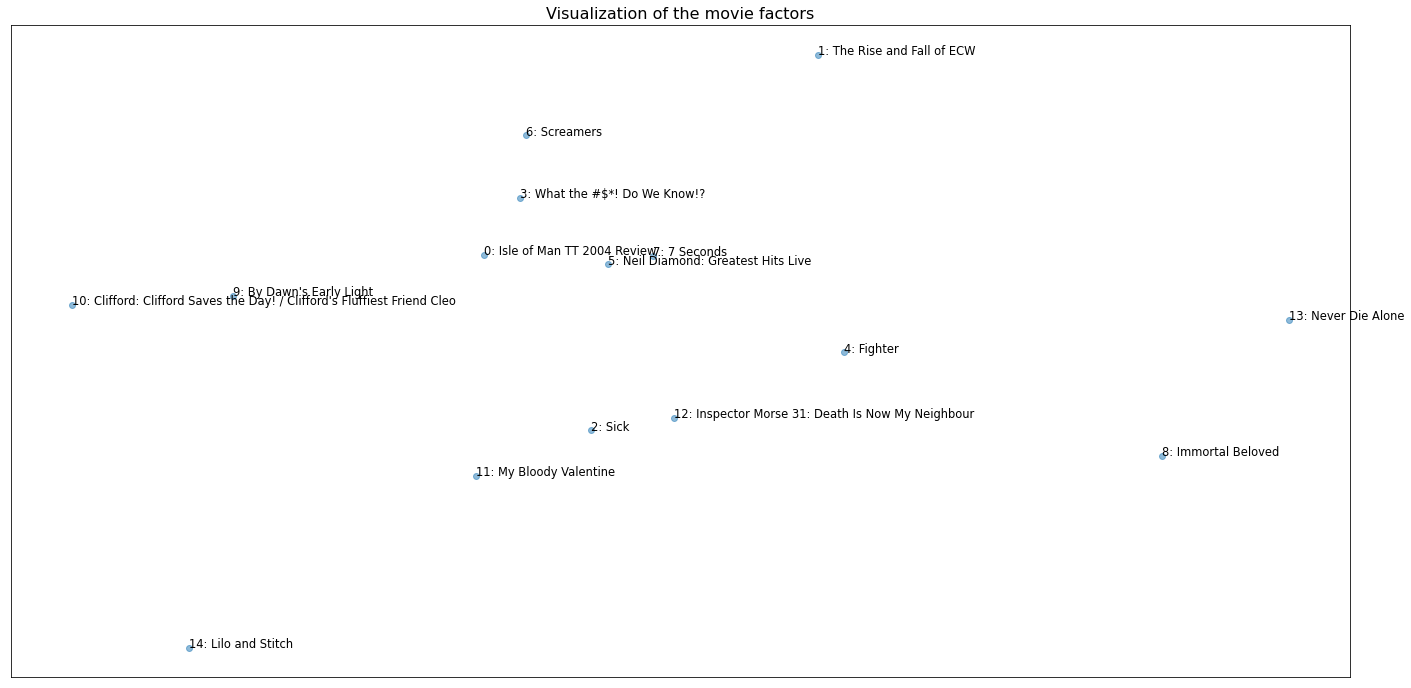

In [40]:
n_samples = 15
projection_plot = projection[:n_samples]
fig, ax = plt.subplots(figsize=(24, 12))
ax.scatter(projection_plot.x.values, projection_plot.y.values, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.grid(False)
ax.set_title('Visualization of the movie factors', size=16)
for i, (mid, txt) in enumerate(zip(projection_plot.Movie_Id_Encoded, projection_plot.Title)):
    ax.annotate('{}: {}'.format(mid, txt), (projection_plot.x.values[i], projection_plot.y.values[i]), fontsize=11.5)